In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
import re
import glob
import nltk
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.wordnet import WordNetLemmatizer
from fit_generator import label_from_id, all_labels
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.preprocessing.text import Tokenizer
from keras import optimizers
from keras.callbacks import ModelCheckpoint 
from fnn_helper import PlotLosses
from keras import regularizers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy
import util
from sklearn.externals import joblib
import iterator_and_text_cleaner as it

Using TensorFlow backend.
/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [3]:
source_path = '../converted/'
txt_files = glob.glob(source_path + '199*/*')
len(txt_files)

202399

In [4]:
NUM_CATEGORIES = 5
Y = np.empty((len(txt_files), NUM_CATEGORIES))
for idx, file in enumerate(txt_files):
    Y[idx] = label_from_id(file)
    Y[idx] /= Y[idx].sum()


In [5]:
Y[0:10]

array([[ 0. ,  0. ,  1. ,  0. ,  0. ],
       [ 0. ,  0. ,  1. ,  0. ,  0. ],
       [ 0.5,  0. ,  0.5,  0. ,  0. ],
       [ 1. ,  0. ,  0. ,  0. ,  0. ],
       [ 1. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  1. ,  0. ],
       [ 1. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  1. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  1. ,  0. ],
       [ 1. ,  0. ,  0. ,  0. ,  0. ]])

In [6]:
count_vectorizer_with_stem = joblib.load('count_vectorizer_with_stem.pkl') 

In [7]:
doc_term = scipy.io.mmread('countvect-articles')
(NUM_ARTICLES, NUM_WORDS) = doc_term.shape

# CountVectorizer como entrada de la red neuronal

Hasta acá tenemos:

* doc_term: matriz de (NUM_ARTICLES, NUM_WORDS) con los count de cada word
* Y: matriz de (NUM_ARTICLES, NUM_CATEGORIES) con los labels

In [8]:
x_train, x_test, y_train, y_test = train_test_split(doc_term, Y, test_size=0.33)
print(x_train.shape, y_train.shape)

(135607, 84168) (135607, 5)


In [9]:
def build_model(layers, optimizer_method, lr=0.1, decay=0.0, model=None):
    if model == None:
        model = Sequential()
        for layer in layers:
            model.add(layer)

    optimizer = optimizer_method(lr=lr, decay=decay)
    model.compile(loss='kullback_leibler_divergence', optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    return model

In [10]:
def batch_generator(X, y, samples_per_epoch, batch_size):
    number_of_batches = samples_per_epoch // batch_size
    counter=0
    shuffle_index = np.arange(np.shape(y)[0])
    np.random.shuffle(shuffle_index)
    X =  X[shuffle_index, :]
    y =  y[shuffle_index]
    while 1:
        index_batch = shuffle_index[batch_size*counter:batch_size*(counter+1)]
        X_batch = X[index_batch,:].todense()
        y_batch = y[index_batch]
        counter += 1
        yield(np.array(X_batch),y_batch)
        if (counter >= number_of_batches):
            np.random.shuffle(shuffle_index)
            counter=0

In [11]:
def train_model(model, x_train, x_test, y_train, y_test, weights_file=None, batch_size=16, epochs=10):
    plot_losses = PlotLosses(plot_interval=1, evaluate_interval=None, x_val=x_test, y_val_categorical=y_test)
    callbacks = [plot_losses]

    if weights_file != None:
        checkpointer = ModelCheckpoint(filepath=weights_file, verbose=0, save_best_only=True)
        callbacks.append(checkpointer)

    steps_per_epoch = x_train.shape[0] // batch_size
    print("Steps per epoch = ", steps_per_epoch)
    generator = batch_generator(x_train, y_train, samples_per_epoch=steps_per_epoch, batch_size=batch_size)
    vals_per_epoc = x_test.shape[0] // batch_size
    val_generator = batch_generator(x_test, y_test, samples_per_epoch=vals_per_epoc, batch_size=batch_size)
    result = model.fit_generator(
        generator,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        validation_data=val_generator,
        validation_steps=vals_per_epoc,
        verbose=1,
        callbacks=callbacks,
    )
    return result

In [12]:
model = build_model(
    [
        Dense(NUM_CATEGORIES, input_dim=NUM_WORDS, activation='softmax'),
    ],
    optimizers.SGD,
    lr=0.002)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5)                 420845    
Total params: 420,845
Trainable params: 420,845
Non-trainable params: 0
_________________________________________________________________


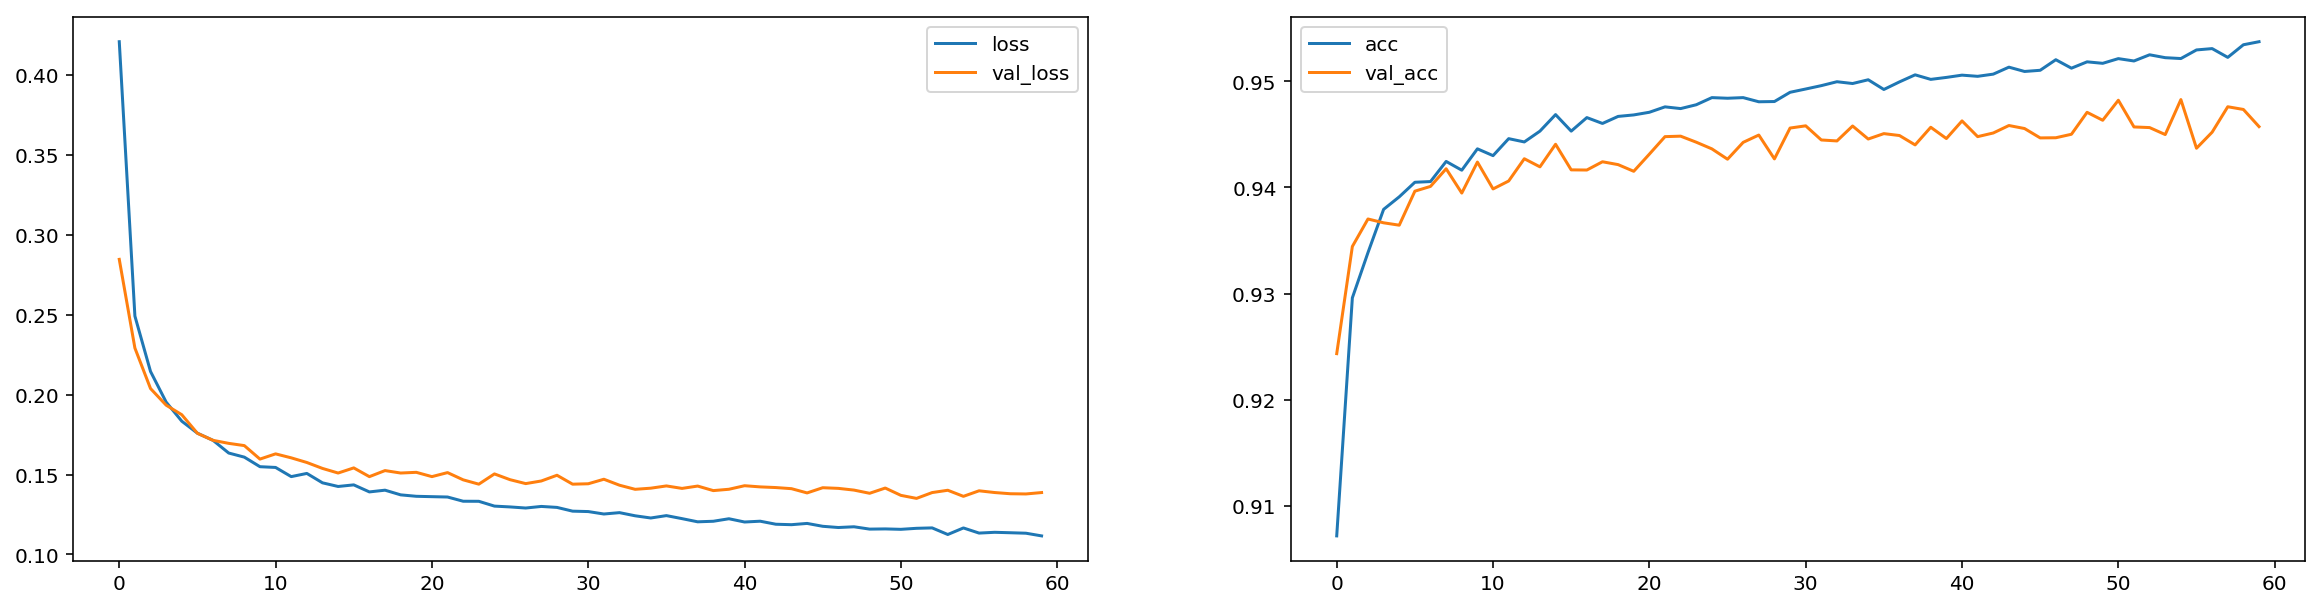

4237/4237 [==============================] - 88s 21ms/step - loss: 0.1116 - acc: 0.9537 - val_loss: 0.1388 - val_acc: 0.9457


In [13]:
train_model(model, x_train, x_test, y_train, y_test, weights_file='countvect1.weights', batch_size=32, epochs=60)

In [14]:
model.load_weights('countvect1.weights')

In [15]:
count_vectorizer = CountVectorizer(
    input='content',
    stop_words='english',
    tokenizer=util.tokenize_and_stem,
    vocabulary=count_vectorizer_with_stem.vocabulary_
)

In [16]:
def predict_from_text(model, text):
    wordcounts = count_vectorizer.fit_transform([text])
    probs = model.predict(wordcounts.todense())
    for i, proba in enumerate(probs[0]):
        if proba > 0.2:
            print(all_labels[i], proba)

In [17]:
cnn_politics = "Today, Democrats hold just one of the 26 Senate seats in the 13 states that, like Alabama,\
have voted Republican in every presidential election since 1992. Republicans in turn hold just one of the 30 \
Senate seats in the 15 states that voted Democratic in all seven presidential elections since then. That means \
if Jones wins he would be just the third senator from the opposing party to hold one of the 56 Senate seats in\
the 28 states that have voted the same way in each of the past seven presidential elections.\
The consistency between presidential and Senate results is much, much greater than it used to be,\
says Alan Abramowitz, a political scientist at Emory University."

predict_from_text(model, cnn_politics)

POLITICS 0.960901


In [18]:
bloomberg = "House and Senate negotiators are planning to limit the deduction for mortgage interest to\
loans of $750,000 or less, according to Representative Tom MacArthur, a New Jersey Republican. MacArthur\
said the $750,000 limit would be positive for his district compared to the House bill. He added that lawmakers\
are still discussing whether to allow a deduction for state and local income taxes as part of a proposed cap of \
$10,000 for property taxes. He also said he’s pushing to preserve a deduction for large medical expenses that \
the House bill would called for eliminating. Current law limits the mortgage deduction to loans of $1 million\
or less. The tax break is one of the sticking points House and Senate lawmakers have been trying to resolve this\
week. The House bill calls for slashing the deduction cap for new purchases of homes in half -- to loans of \
$500,000 or less. The Senate legislation preserved the current limit."

predict_from_text(model, bloomberg)

ECONOMICS 0.64129
POLITICS 0.350667


In [19]:
bloomberg2 = "Despite a recent bounce back, analysts and investors say the greenback could lose more ground\
against the euro and yen as the prospect of strong economic growth and tighter monetary policy outside the \
U.S. more than offsets higher interest rates at home. The dollar is down more than 7 percent versus the world’s\
major currencies this year, the most in over a decade. The economic growth “we’re seeing in Europe, emerging \
markets and the rest of the world will likely cause the dollar to sell off again,” said Erin Browne, the head \
of asset allocation at UBS Asset Management, which oversees about $770 billion. When it comes to what central\
banks in Europe and Japan might do, “there’s very little priced in.”"

predict_from_text(model, bloomberg2)

ECONOMICS 0.853077


In [20]:
cnn_sports = "With 14 wins and just one draw so far, Manchester City are on pace to pull off the most dominant\
season in Premier League history -- but can they go undefeated? Since drawing with Everton in their second \
league game of the season, Pep Guardiola's City has won 13-matches in a row while posting a staggering 36 \
goal difference. heir Champions League performances been nearly as impressive, with City winning its first \
five matches and locking up the group before losing to Shakhtar Donetsk earlier this week."

predict_from_text(model, cnn_sports)

SPORTS 0.994871


In [21]:
cnn_entertainment = "Disney's next installment in the \"Star Wars\" saga has become Fandango's top advance \
ticket-seller of the year, the online ticket site reported on Tuesday. The film, which doesn't officially open \
in North America until Friday with previews beginning Thursday night, toppled another Disney production, \
\"Beauty and the Beast,\" which came out in March, for the top spot. \"The Last Jedi\" is the biggest \
ticket pre-seller for Fandango since the series' last film, 2015's \"Star Wars: The Force Awakens,\" which \
went on to become the biggest opening in film history. \"The Last Jedi\" debuts in more than 4,100 \
theaters domestically and is on track for an opening weekend in the $200 million range. However, \
some box office analysts are saying the movie has the chance to open even higher. Fandango also put \
together some interesting data on why audiences are looking forward to the film, which stars Mark Hamill\
as Luke Skywalker and Daisy Ridley as Rey."

predict_from_text(model, cnn_entertainment)

ENTERTAINMENT 0.965576


In [22]:
cnn_tech = "The internet company released a trio of free photo apps on Monday. Created as experiments by different \
Google (GOOG) departments, the simple mobile apps include a photo booth with pose-detecting powers, a way\
to remix videos like a DJ, and a tool for turning any mundane adventure into a comic book panel.\
The company is calling the free downloads Appsperiments, a clunky portmanteau of apps and experiments.\
The tools offer a peek into the future of smartphone photography, which will increasingly rely on effects \
created by software. An early example is the Google Pixel 2 portrait mode, which uses software to fake a \
shallow depth-of-field effect. The next generation of cameras will have the capability to blend hardware\
and computer vision algorithms,\" said Alex Kauffmann, an interaction researcher at Google Research, in a blog post."

predict_from_text(model, cnn_tech)

TECHNOLOGY 0.510567


## Análisis de la influencia de las top 100 palabras en cada categoría

Se toman los pesos de cada neurona de salida y se los ordena en forma ascendente para saber a qué palabras pertenecen dichos pesos.

In [23]:
weights, bias = model.get_weights()

In [24]:
idx2voc = np.array(count_vectorizer_with_stem.get_feature_names())

In [25]:
for label_idx, label in enumerate(all_labels):
    print('-----', label, '-----')
    sorted_weights = np.argsort(weights[:,label_idx])[::-1][0:100]
    print(idx2voc[sorted_weights])
    print()

----- ECONOMICS -----
['moody' 'newsroom' 'pct' 'mln' 'desk' 'bond' 'obligation' 'coupon' 'trade'
 'issuer' 'bln' 'bank' 'strike' 'sanction' 'economic' 'municipal' 'job'
 'worker' 'statistic' 'employee' 'percent' 'series' 'cty' 'frankfurt' 'tax'
 'economy' 'minister' 'aaa' 'aid' 'finance' 'cost' 'sale' 'true' 'balance'
 'reserve' 'dollar' 'date' 'humanitarian' 'rate' 'foreign' 'maturity'
 'union' 'refund' 'net' 'indicator' 'yield' 'rise' 'treasury' 'teamster'
 'government' 'import' 'rat' 'export' 'inflation' 'loan' 'labour' 'wto'
 'texaco' 'price' 'april' 'barney' 'delivery' 'index' 'figure' 'currency'
 'feed' 'hoffa' 'budget' 'mfn' 'intervention' 'summit' 'cut' 'amt'
 'cooperation' 'roosevelt' 'business' 'monetary' 'clinton' 'manufacture'
 'debt' 'billion' 'embargo' 'workforce' 'csd' 'cusip' 'central' 'security'
 'employ' 'general' 'visit' 'leader' 'quarter' 'privatisation' 'assistance'
 'airline' 'carey' 'mich' 'bundesbank' 'prudential' 'merrill']

----- ENTERTAINMENT -----
['film' '

**NOTA**: Se nota que en tecnología en realidad se están categorizando artítulos que perteneces más bien a ciencia y no tanto a tecnología, y dado que son artículos de 1996/1197, no hay palabras *modernas* tales como Apple, Google, etc.

## Análisis de predicciones exactas

La idea es utilizar el test set para ver cuánta predicciones dan como resultado exacto, es decir, coinciden los 5 valores de las categorías.

In [26]:
predictions = model.predict(x_test.todense())

In [27]:
predictions.shape

(66792, 5)

In [28]:
prefect_predictions = 0
for idx, pred in enumerate(predictions):
    if ((pred > .5) == (y_test[idx] > .5)).sum() == NUM_CATEGORIES:
        prefect_predictions += 1
prefect_predictions    

60197

In [29]:
prefect_predictions / predictions.shape[0]

0.9012606300155708

In [30]:
total_loss = 0
for idx, pred in enumerate(predictions):
    total_loss += np.logical_xor(pred> .5, y_test[idx] > .5).sum()

In [31]:
total_loss / predictions.shape[0] / NUM_CATEGORIES

0.024973050664750269

## Otra forma de calcular la exactitud teniendo en cuenta aciertos parciales

In [32]:
pred_sum = 0
for idx, pred in enumerate(predictions):
    r = ((pred > .5) * y_test[idx]).sum() / y_test[idx].sum()
    pred_sum += r
pred_sum / predictions.shape[0]

0.93327544216872282